In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [0]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    train_data.data = train_data.data[:1000,:,:]
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()
    
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [0]:
train_loader, test_loader = mnist(1)

In [0]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1e-4)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for name, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [0]:
models = {'F.softmax': Net(), 'log_softmax': Net(True)}
test_log = {k: [] for k in models}

In [0]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader.dataset), p)
line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models, log=None):
    test_size = len(test_loader.sampler)
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models.keys():
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models.keys():
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [54]:
for epoch in range(1, 501):
    train(epoch, models)
    test(models, test_log)

Streaming output truncated to the last 5000 lines.
Train Epoch: 1 [200/1000 (20%)]	Losses F.softmax: 2.337541 log_softmax: 2.316493
Train Epoch: 1 [400/1000 (40%)]	Losses F.softmax: 2.325866 log_softmax: 2.320865
Train Epoch: 1 [600/1000 (60%)]	Losses F.softmax: 2.331181 log_softmax: 2.306338
Train Epoch: 1 [800/1000 (80%)]	Losses F.softmax: 2.334376 log_softmax: 2.337328
Train Epoch: 1 [1000/1000 (100%)]	Losses F.softmax: 2.221020 log_softmax: 2.328003
Test set:
F.softmax: Loss: 2.3017	Accuracy: 954.0/10000 (10%)
log_softmax: Loss: 2.3026	Accuracy: 980.0/10000 (10%)

Train Epoch: 2 [0/1000 (0%)]	Losses F.softmax: 2.230298 log_softmax: 2.323147
Train Epoch: 2 [200/1000 (20%)]	Losses F.softmax: 2.305220 log_softmax: 2.286254
Train Epoch: 2 [400/1000 (40%)]	Losses F.softmax: 2.333586 log_softmax: 2.321257
Train Epoch: 2 [600/1000 (60%)]	Losses F.softmax: 2.267598 log_softmax: 2.306463
Train Epoch: 2 [800/1000 (80%)]	Losses F.softmax: 2.309756 log_softmax: 2.297863
Train Epoch: 2 [1000/10

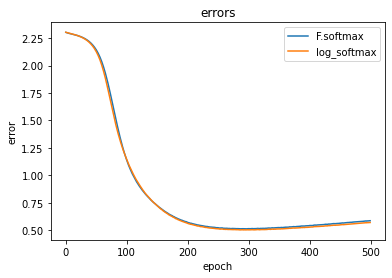

In [55]:
plot_graphs(test_log, 'loss')

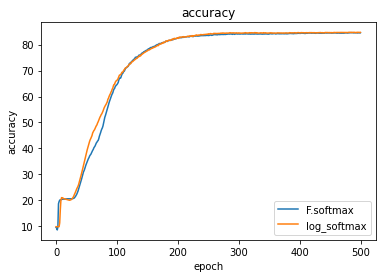

In [56]:
plot_graphs(test_log, 'accuracy')

In [32]:
test_log

{'F.softmax': [(2.346628357028961, tensor(10.3200)),
  (2.3340728853225707, tensor(10.3200)),
  (2.3254540694236754, tensor(10.3200)),
  (2.319427324485779, tensor(10.3200)),
  (2.3151577219963073, tensor(10.3200)),
  (2.311979053783417, tensor(10.3200)),
  (2.309715236854553, tensor(10.3200)),
  (2.3080407976150514, tensor(10.3200)),
  (2.306786625480652, tensor(10.3200)),
  (2.3058515606880188, tensor(12.7300)),
  (2.3051628129959107, tensor(10.2800)),
  (2.3046465989112854, tensor(10.2800)),
  (2.304237362766266, tensor(10.2800)),
  (2.303939515686035, tensor(10.2800)),
  (2.3037228024482728, tensor(10.2800)),
  (2.303542326831818, tensor(10.2800)),
  (2.303411889839172, tensor(10.2800)),
  (2.303296516895294, tensor(10.2800)),
  (2.3031931060791018, tensor(10.2800)),
  (2.3031310984611513, tensor(10.2800)),
  (2.3030977776527406, tensor(10.2800)),
  (2.3030432970046997, tensor(10.2800)),
  (2.3030055475234987, tensor(10.2800)),
  (2.3029924315452575, tensor(10.2800)),
  (2.30295327